# 1. 载入数据

首先记得指明你的data_dir：

In [1]:
data_dir = './data/Aluminum/'

In [2]:
import tensorflow

In [3]:
import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import imagenet_utils

In [5]:
import warnings
warnings.filterwarnings('ignore')

读取子文件的名称作为真实的类别标签：

In [6]:
os.listdir(data_dir)

['blister',
 'bump',
 'coating_crack',
 'convexity',
 'damage',
 'dirty_spot',
 'indentation',
 'jet_flow',
 'orange_peel',
 'rub_mark']

In [7]:
labels = os.listdir(data_dir)

然后可以读取子文件夹里面的每张图片作为输入：

In [8]:
os.path.join(data_dir, labels[0])

'./data/Aluminum/blister'

In [9]:
os.listdir(os.path.join(data_dir, labels[0]))

['blister_1.jpg',
 'blister_10.jpg',
 'blister_11.jpg',
 'blister_12.jpg',
 'blister_13.jpg',
 'blister_14.jpg',
 'blister_15.jpg',
 'blister_16.jpg',
 'blister_17.jpg',
 'blister_18.jpg',
 'blister_19.jpg',
 'blister_2.jpg',
 'blister_20.jpg',
 'blister_21.jpg',
 'blister_22.jpg',
 'blister_3.jpg',
 'blister_4.jpg',
 'blister_5.jpg',
 'blister_6.jpg',
 'blister_7.jpg',
 'blister_8.jpg',
 'blister_9.jpg']

记录对应的图片完整路径和对应的标签：

In [10]:
X_list = []
y_list = []
labels = os.listdir(data_dir)
for label in labels:
    label_path = os.path.join(data_dir, label)
    fns = os.listdir(label_path)
    for fn in fns:
        X_list.append(os.path.join(label_path, fn))
        y_list.append(label)

In [11]:
X_list[:5]

['./data/Aluminum/blister\\blister_1.jpg',
 './data/Aluminum/blister\\blister_10.jpg',
 './data/Aluminum/blister\\blister_11.jpg',
 './data/Aluminum/blister\\blister_12.jpg',
 './data/Aluminum/blister\\blister_13.jpg']

In [12]:
y_list[:5]

['blister', 'blister', 'blister', 'blister', 'blister']

In [13]:
X_list[-5:]

['./data/Aluminum/rub_mark\\rub_mark_5.jpg',
 './data/Aluminum/rub_mark\\rub_mark_6.jpg',
 './data/Aluminum/rub_mark\\rub_mark_7.jpg',
 './data/Aluminum/rub_mark\\rub_mark_8.jpg',
 './data/Aluminum/rub_mark\\rub_mark_9.jpg']

In [14]:
y_list[-5:]

['rub_mark', 'rub_mark', 'rub_mark', 'rub_mark', 'rub_mark']

In [15]:
len(X_list)

372

In [16]:
len(y_list)

372

转换为DataFrame的格式：

In [17]:
import pandas as pd
df = pd.DataFrame({'X': X_list, 'y_name': y_list}, index=range(len(X_list)))

In [18]:
df.head()

,X,y_name
0,./data/Aluminum/blister\blister_1.jpg,blister
1,./data/Aluminum/blister\blister_10.jpg,blister
2,./data/Aluminum/blister\blister_11.jpg,blister
3,./data/Aluminum/blister\blister_12.jpg,blister
4,./data/Aluminum/blister\blister_13.jpg,blister


将类别名称进行编码：

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['y'] = encoder.fit_transform(df['y_name'])

In [20]:
df.head()

,X,y_name,y
0,./data/Aluminum/blister\blister_1.jpg,blister,0
1,./data/Aluminum/blister\blister_10.jpg,blister,0
2,./data/Aluminum/blister\blister_11.jpg,blister,0
3,./data/Aluminum/blister\blister_12.jpg,blister,0
4,./data/Aluminum/blister\blister_13.jpg,blister,0


In [21]:
max(df['y'])

9

一共9+1=10种类别。

In [22]:
num_classes = max(df['y']) + 1

In [23]:
num_classes

10

因此这个问题我们要处理的是一个10-分类问题。

接下来进行数据集的划分：

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 按照y进行分层采样
# 20%的数据作为测试集
for train_index, test_index in split.split(df, df['y']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [25]:
strat_train_set.shape

(297, 3)

In [26]:
strat_test_set.shape

(75, 3)

In [27]:
strat_train_set.head()

,X,y_name,y
97,./data/Aluminum/convexity\convexity_2.jpg,convexity,3
317,./data/Aluminum/orange_peel\orange_peel_23.jpg,orange_peel,8
345,./data/Aluminum/orange_peel\orange_peel_8.jpg,orange_peel,8
287,./data/Aluminum/jet_flow\jet_flow_34.jpg,jet_flow,7
106,./data/Aluminum/convexity\convexity_28.jpg,convexity,3


接下来利用ImageDataGenerator来准备训练用的generator

In [28]:
# 图像归一化
# 并且划分20%的训练集数据作为验证集数据
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 设置小批量的大小
batch_size = 8
# 统一图片的分辨率
target_size = (256, 256)

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
train_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col='X',
                                            y_col='y',
                                            subset="training",
                                            seed=44,  # 随机数种子
                                            # class_mode="sparse", # 直接使用文本标签
                                            class_mode='raw',  # 用整数标签
                                            target_size=target_size,  # 这里把图片调整大小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

# 划分验证集
valid_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col='X',
                                            y_col='y',
                                            subset="validation",
                                            seed=44,  # 随机数种子
                                            # class_mode="sparse", # 直接使用文本标签
                                            class_mode='raw',  # 用整数标签
                                            target_size=target_size,  # 这里把图片调整大小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

Found 238 validated image filenames.
Found 59 validated image filenames.


分别查看训练集和验证集的数据量：

In [29]:
train_generator.n

238

In [30]:
train_generator.batch_size

8

In [31]:
valid_generator.n

59

In [32]:
valid_generator.batch_size

8

In [33]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape)
    print(y_batch.shape)
    break

(8, 256, 256, 3)
(8,)


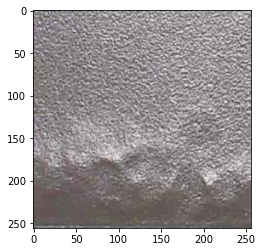

In [34]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_batch[0])

In [35]:
y_batch[0]

3

可以看到已经train_generator已经可以自动读取图像了

类似的，我们构建test_generator

In [36]:
# 图像归一化
datagen=ImageDataGenerator(rescale=1./255)

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
test_generator=datagen.flow_from_dataframe(dataframe=strat_test_set, 
                                            x_col='X',
                                            y_col='y',
                                            # class_mode="sparse", # 直接使用文本标签
                                            class_mode='raw',  # 用整数标签
                                            target_size=target_size,  # 这里把图片调整大小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

Found 75 validated image filenames.


In [37]:
test_generator.n

75

In [38]:
test_generator.batch_size

8

# 2. 模型尝试

首先尝试一个最简单的模型：

In [39]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

def build_model():
    input = Input(shape=(256, 256, 3))
    X = Conv2D(32, (3, 3), activation='relu')(input)
    X = MaxPooling2D((2, 2))(X)
    X = Conv2D(64, (3, 3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Conv2D(128, (3, 3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Conv2D(128, (3, 3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Flatten()(X)
    X = Dense(512, activation='relu')(X)
    # 改为输出的类别
    X = Dense(num_classes, activation='softmax')(X)
    model = Model(inputs=input, outputs=X)
    return model

model = build_model()

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856 

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001,decay = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 8

history0 = model.fit(train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n // valid_generator.batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/30
29/29 [==============================] - 4s 44ms/step - loss: 2.2449 - accuracy: 0.1217 - val_loss: 2.0970 - val_accuracy: 0.4286
Epoch 2/30
29/29 [==============================] - 1s 21ms/step - loss: 1.9359 - accuracy: 0.3652 - val_loss: 1.5777 - val_accuracy: 0.5714
Epoch 3/30
29/29 [==============================] - 1s 21ms/step - loss: 1.5129 - accuracy: 0.5696 - val_loss: 1.3341 - val_accuracy: 0.5179
Epoch 4/30
29/29 [==============================] - 1s 21ms/step - loss: 1.1873 - accuracy: 0.6348 - val_loss: 0.8689 - val_accuracy: 0.7679
Epoch 5/30
29/29 [==============================] - 1s 21ms/step - loss: 0.9902 - accuracy: 0.7130 - val_loss: 0.8147 - val_accuracy: 0.7679
Epoch 6/30
29/29 [==============================] - 1s 21ms/step - loss: 0.8714 - accuracy: 0.7261 - val_loss: 0.8062 - val_accuracy: 0.7857
Epoch 7/30
29/29 [==============================] - 1s 21ms/step - loss: 0.7828 - accuracy: 0.7652 - val_loss: 0.7078 - val_accuracy: 0.8214
Epoch 8/30
29

我们在测试集上进行评估：

In [42]:
loss, acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
acc

9/9 [==============================] - 0s 15ms/step - loss: 0.7402 - accuracy: 0.8056


0.8055555820465088

这是采用一个简单的模型能取得的准确率。

可以画出训练过程：

In [43]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 20

In [44]:
def plot_training(history, save_fn):
    import pandas as pd
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
             label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
             label = 'Validation Accuracy')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

In [45]:
def plot_training_loss(history, save_fn):
    import pandas as pd
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Validation Loss')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

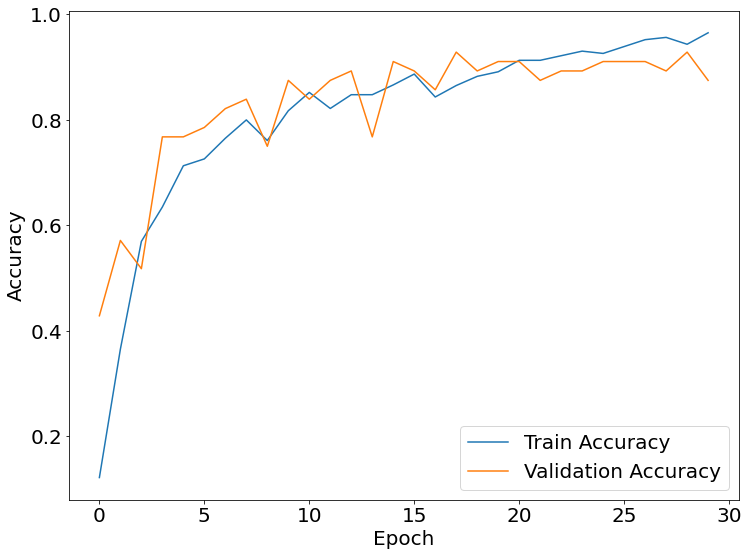

In [46]:
plot_training(history0, 'training1.png')

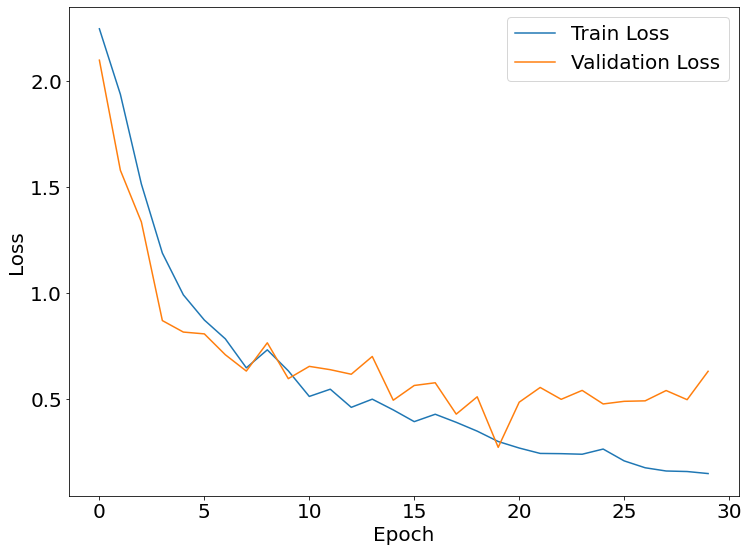

In [47]:
plot_training_loss(history0, 'loss1.png')

# 进一步评估结果

获取测试集上的真实标签：

In [48]:
y_true = strat_test_set['y'].values
y_true[:5]

array([8, 0, 7, 2, 5])

获取测试集上的预测标签：

In [49]:
import numpy as np

y_pred_proba = []
y_pred = []
for fn in strat_test_set['X'].values:
    img = load_img(fn, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.  # rescale
    img = np.expand_dims(img, axis=0)
    pred_proba = model.predict(img, verbose=0)[0]
    y_pred_proba.append(pred_proba)
    pred = np.argmax(pred_proba)
    y_pred.append(pred)

In [87]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sn
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

查看classification report：

In [51]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.80      0.67      0.73         6
           2       1.00      1.00      1.00         7
           3       0.80      0.89      0.84         9
           4       0.80      0.57      0.67         7
           5       0.80      0.89      0.84         9
           6       0.71      1.00      0.83        10
           7       0.90      1.00      0.95         9
           8       0.80      0.89      0.84         9
           9       0.75      0.60      0.67         5

    accuracy                           0.81        75
   macro avg       0.74      0.75      0.74        75
weighted avg       0.77      0.81      0.79        75



# DenseNet尝试

In [109]:
from keras.applications import *

In [110]:
num_classes = 10
input_shape=(256, 256, 3)

In [111]:
base_model = DenseNet121(include_top=False, input_shape=input_shape) 

# 添加a fully-connected layer
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# 我们最终会训练的模型
densenet_model = Model(inputs=base_model.input, outputs=predictions)

In [112]:
densenet_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

 conv2_block4_0_relu (Activatio  (None, 64, 64, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 64, 64, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 32, 32, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 32, 32, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 32, 32, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 32, 32, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 32, 32, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 16, 16, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 16, 16, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 16, 16, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 16, 16, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 16, 16, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 16, 16, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 16, 16, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 16, 16, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 16, 16, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 16, 16, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 8, 8, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 8, 8, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 8, 8, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 8, 8, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 8, 8, 128)    98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 8, 8, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
Total params: 23,817,546
Trainable params: 23,733,898
Non-trainable params: 83,648
__________________________________________________________________________________________________


可以看到Total params

In [113]:
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001,decay = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 8

history_densenet = densenet_model.fit(train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n // valid_generator.batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/30
29/29 [==============================] - 22s 249ms/step - loss: 3.6943 - accuracy: 0.3348 - val_loss: 1.6434 - val_accuracy: 0.4643
Epoch 2/30
29/29 [==============================] - 5s 182ms/step - loss: 1.0778 - accuracy: 0.6826 - val_loss: 1.4958 - val_accuracy: 0.5179
Epoch 3/30
29/29 [==============================] - 4s 154ms/step - loss: 0.4945 - accuracy: 0.8304 - val_loss: 0.9889 - val_accuracy: 0.6429
Epoch 4/30
29/29 [==============================] - 4s 147ms/step - loss: 0.3459 - accuracy: 0.8793 - val_loss: 1.1009 - val_accuracy: 0.6071
Epoch 5/30
29/29 [==============================] - 4s 147ms/step - loss: 0.2378 - accuracy: 0.9217 - val_loss: 0.6734 - val_accuracy: 0.7857
Epoch 6/30
29/29 [==============================] - 4s 153ms/step - loss: 0.1125 - accuracy: 0.9609 - val_loss: 0.6713 - val_accuracy: 0.8036
Epoch 7/30
29/29 [==============================] - 4s 146ms/step - loss: 0.1072 - accuracy: 0.9609 - val_loss: 0.3826 - val_accuracy: 0.9107
Epoch

In [114]:
loss, acc = densenet_model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
acc

9/9 [==============================] - 0s 44ms/step - loss: 0.4445 - accuracy: 0.8889


0.8888888955116272

In [115]:
import numpy as np

y_pred_proba = []
y_pred = []
for fn in strat_test_set['X'].values:
    img = load_img(fn, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.  # rescale
    img = np.expand_dims(img, axis=0)
    pred_proba = densenet_model.predict(img, verbose=0)[0]
    y_pred_proba.append(pred_proba)
    pred = np.argmax(pred_proba)
    y_pred.append(pred)

In [116]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         7
           3       1.00      0.89      0.94         9
           4       1.00      0.71      0.83         7
           5       0.73      0.89      0.80         9
           6       0.91      1.00      0.95        10
           7       0.82      1.00      0.90         9
           8       1.00      0.89      0.94         9
           9       1.00      0.80      0.89         5

    accuracy                           0.89        75
   macro avg       0.90      0.87      0.88        75
weighted avg       0.90      0.89      0.89        75



In [117]:
f1_score(y_true, y_pred, average='macro')

0.8751461610285141

In [118]:
accuracy_score(y_true, y_pred)

0.8933333333333333

# 更多模型尝试

In [80]:
base_model = VGG19(include_top=False, input_shape=input_shape) 

# 添加a fully-connected layer
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# 我们最终会训练的模型
vgg19_model = Model(inputs=base_model.input, outputs=predictions)

80134624/80134624 [==============================] - 16s 0us/step


In [81]:
vgg19_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [82]:
vgg19_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001,decay = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 8  # 内存不足，改小

history_vgg19 = vgg19_model.fit(train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n // valid_generator.batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/30
29/29 [==============================] - 11s 230ms/step - loss: 2.4005 - accuracy: 0.1435 - val_loss: 1.9388 - val_accuracy: 0.1786
Epoch 2/30
29/29 [==============================] - 4s 146ms/step - loss: 2.1358 - accuracy: 0.2522 - val_loss: 1.6979 - val_accuracy: 0.3214
Epoch 3/30
29/29 [==============================] - 4s 144ms/step - loss: 2.0779 - accuracy: 0.2261 - val_loss: 2.3055 - val_accuracy: 0.1071
Epoch 4/30
29/29 [==============================] - 4s 145ms/step - loss: 2.2303 - accuracy: 0.1652 - val_loss: 2.0284 - val_accuracy: 0.2321
Epoch 5/30
29/29 [==============================] - 4s 146ms/step - loss: 1.7893 - accuracy: 0.3565 - val_loss: 1.3135 - val_accuracy: 0.4821
Epoch 6/30
29/29 [==============================] - 4s 147ms/step - loss: 1.5421 - accuracy: 0.4217 - val_loss: 1.1583 - val_accuracy: 0.5536
Epoch 7/30
29/29 [==============================] - 4s 146ms/step - loss: 1.3047 - accuracy: 0.5565 - val_loss: 1.0217 - val_accuracy: 0.6607
Epoch

In [83]:
loss, acc = vgg19_model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
acc

9/9 [==============================] - 0s 48ms/step - loss: 0.9155 - accuracy: 0.8750


0.875

In [84]:
import numpy as np

y_pred_proba = []
y_pred = []
for fn in strat_test_set['X'].values:
    img = load_img(fn, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.  # rescale
    img = np.expand_dims(img, axis=0)
    pred_proba = vgg19_model.predict(img, verbose=0)[0]
    y_pred_proba.append(pred_proba)
    pred = np.argmax(pred_proba)
    y_pred.append(pred)

In [85]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.75      1.00      0.86         6
           2       1.00      1.00      1.00         7
           3       1.00      0.89      0.94         9
           4       0.83      0.71      0.77         7
           5       0.75      1.00      0.86         9
           6       1.00      1.00      1.00        10
           7       0.86      0.67      0.75         9
           8       1.00      0.89      0.94         9
           9       0.67      0.80      0.73         5

    accuracy                           0.88        75
   macro avg       0.89      0.87      0.87        75
weighted avg       0.90      0.88      0.88        75



In [86]:
f1_score(y_true, y_pred, average='macro')

0.8700285009108539

In [88]:
accuracy_score(y_true, y_pred)

0.88

In [139]:
base_model = InceptionV3(include_top=False, input_shape=input_shape) 

# 添加a fully-connected layer
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# 我们最终会训练的模型
inception_model = Model(inputs=base_model.input, outputs=predictions)

In [138]:
inception_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_192 (Conv2D)            (None, 127, 127, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 127, 127, 32  96         ['conv2d_192[0][0]']             
 Normalization)                 )                                                          

 conv2d_203 (Conv2D)            (None, 29, 29, 32)   6144        ['average_pooling2d_18[0][0]']   
                                                                                                  
 batch_normalization_193 (Batch  (None, 29, 29, 64)  192         ['conv2d_197[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_195 (Batch  (None, 29, 29, 64)  192         ['conv2d_199[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 29, 29, 96)  288         ['conv2d_202[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_214 (Conv2D)            (None, 29, 29, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_210 (Batch  (None, 29, 29, 64)  192         ['conv2d_214[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_210 (Activation)    (None, 29, 29, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_212 (Conv2D)            (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_21

                                                                                                  
 activation_217 (Activation)    (None, 14, 14, 96)   0           ['batch_normalization_217[0][0]']
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_22

 mixed4 (Concatenate)           (None, 14, 14, 768)  0           ['activation_218[0][0]',         
                                                                  'activation_221[0][0]',         
                                                                  'activation_226[0][0]',         
                                                                  'activation_227[0][0]']         
                                                                                                  
 conv2d_236 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 14, 14, 160)  480        ['conv2d_236[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_246 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_242 (Batch  (None, 14, 14, 160)  480        ['conv2d_246[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_247 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 14, 14, 160)  480        ['conv2d_247[0][0]']             
 Normaliza

 activation_252 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_252[0][0]']
                                                                                                  
 conv2d_257 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 14, 14, 192)  576        ['conv2d_257[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_253 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_261 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_262 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_266 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 14, 14, 192)  576        ['conv2d_262[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_276 (Conv2D)            (None, 6, 6, 192)    245760      ['average_pooling2d_25[0][0]']   
                                                                                                  
 batch_normalization_264 (Batch  (None, 6, 6, 320)   960         ['conv2d_268[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_266 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_267[0][0]']
          

                                                                                                  
 activation_275 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_275[0][0]']
                                                                                                  
 activation_276 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_279 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_279[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 6, 6, 192)   576         ['conv2d_285[0][0]']             
 Normaliza

In [140]:
inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001,decay = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 8  # 内存不足，改小

history_inception = inception_model.fit(train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n // valid_generator.batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/30
29/29 [==============================] - 21s 248ms/step - loss: 3.4143 - accuracy: 0.4043 - val_loss: 2.0267 - val_accuracy: 0.3036
Epoch 2/30
29/29 [==============================] - 4s 148ms/step - loss: 1.0294 - accuracy: 0.7304 - val_loss: 1.4267 - val_accuracy: 0.5714
Epoch 3/30
29/29 [==============================] - 4s 144ms/step - loss: 0.5134 - accuracy: 0.8000 - val_loss: 1.1904 - val_accuracy: 0.6429
Epoch 4/30
29/29 [==============================] - 6s 210ms/step - loss: 0.2152 - accuracy: 0.9130 - val_loss: 0.9765 - val_accuracy: 0.7679
Epoch 5/30
29/29 [==============================] - 9s 286ms/step - loss: 0.2126 - accuracy: 0.9435 - val_loss: 1.0021 - val_accuracy: 0.7500
Epoch 6/30
29/29 [==============================] - 4s 149ms/step - loss: 0.2363 - accuracy: 0.9087 - val_loss: 1.0231 - val_accuracy: 0.7321
Epoch 7/30
29/29 [==============================] - 4s 153ms/step - loss: 0.1824 - accuracy: 0.9522 - val_loss: 0.7574 - val_accuracy: 0.8393
Epoch

In [141]:
loss, acc = inception_model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
acc

9/9 [==============================] - 0s 44ms/step - loss: 0.6399 - accuracy: 0.8889


0.8888888955116272

In [142]:
import numpy as np

y_pred_proba = []
y_pred = []
for fn in strat_test_set['X'].values:
    img = load_img(fn, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.  # rescale
    img = np.expand_dims(img, axis=0)
    pred_proba = inception_model.predict(img, verbose=0)[0]
    y_pred_proba.append(pred_proba)
    pred = np.argmax(pred_proba)
    y_pred.append(pred)

In [143]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         7
           3       0.89      0.89      0.89         9
           4       0.83      0.71      0.77         7
           5       0.64      1.00      0.78         9
           6       1.00      1.00      1.00        10
           7       1.00      0.89      0.94         9
           8       1.00      0.89      0.94         9
           9       1.00      0.80      0.89         5

    accuracy                           0.89        75
   macro avg       0.92      0.87      0.88        75
weighted avg       0.92      0.89      0.89        75



In [144]:
f1_score(y_true, y_pred, average='macro')

0.8801713773580782

In [145]:
accuracy_score(y_true, y_pred)

0.8933333333333333